In [5]:
!pip install pingouin category_encoders pydotplus pandas matplotlib sklearn seaborn numpy
import warnings
warnings.filterwarnings("ignore")

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [6]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import pingouin as pgimport 
from scipy.stats import chi2  
from scipy.stats import chi2_contingency  
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC  
from sklearn import tree  
from sklearn.tree import export_graphviz  
from six import StringIO  
from sklearn.linear_model import Perceptron  
from sklearn.neural_network import MLPClassifier  
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix 
from category_encoders import BinaryEncoder  
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt  
%matplotlib inline  
color = sns.color_palette()
seed = 42

# Predict probability of default
## Reading Data and preparing target

In [7]:
df = pd.read_csv('loan_data.csv')

In [8]:
df.head(2)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        NaN      NaN              NaN    NaN   
1         NaN          NaN        NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  

[2 rows x 74 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [ ]:
for i in range(73) :
    if ( df.isna().sum()[i] >0 ):
        print( (df.isna().sum()[i]/len(df)) *100, "\t",df.isna().sum().index[i] )

In [10]:
# Drop all columns with null> 70%
list=['total_cu_tl','inq_fi','all_util','max_bal_bc','open_rv_24m','open_rv_12m','il_util','total_bal_il','mths_since_rcnt_il','open_il_24m','open_il_12m','open_il_6m','open_acc_6m','verification_status_joint','dti_joint','dti_joint','mths_since_last_record','mths_since_last_major_derog','desc']
df.drop(list, axis=1, inplace=True)

In [11]:
df.drop(['annual_inc_joint','inq_last_12m'], axis=1, inplace=True)

In [10]:
for i in range(54) :
    if ( df.isna().sum()[i] >0 ):
        print( (df.isna().sum()[i]/len(df)) *100, "\t",df.isna().sum().index[i] )

5.916553180994456 	 emp_title
4.505399058515715 	 emp_length


KeyboardInterrupt: 

In [ ]:
18 features with more than 80% of missing values
useless: id, member_id, url, title
    forward-looking features that are expected to be populated only once the borrower has defaulted, e.g., recoveries, collection_recovery_fee

In [12]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [13]:
df[['recoveries','total_rec_late_fee', 'total_rec_int', 'total_rec_prncp','collection_recovery_fee']].head(2) #after default variables

recoveries  total_rec_late_fee  total_rec_int  total_rec_prncp  \
0        0.00                 0.0         861.07          5000.00   
1      117.08                 0.0         435.17           456.46   

   collection_recovery_fee  
0                     0.00  
1                     1.11

In [14]:
df[['emp_title','url', 'purpose', 'title','zip_code', 'addr_state','title']].head(2)

emp_title                                                url      purpose  \
0       NaN  https://www.lendingclub.com/browse/loanDetail....  credit_card   
1     Ryder  https://www.lendingclub.com/browse/loanDetail....          car   

      title zip_code addr_state     title  
0  Computer    860xx         AZ  Computer  
1      bike    309xx         GA      bike

In [15]:
df.drop(['id','member_id','url'], axis=1, inplace=True)

In [16]:
df.drop(['recoveries','total_rec_late_fee', 'total_rec_int', 'total_rec_prncp','collection_recovery_fee'], axis=1, inplace=True)

df.describe()

In [17]:
target = 'loan_status'
df[target].value_counts(normalize = True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [19]:
#Any NA Values in target ?
print(df[target].isna().sum()  )

0


In [20]:
value=['Fully Paid','Charged Off','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off','Default']
df_new=df.loc[df[target].isin(value)]

In [21]:
df_new[target].value_counts()

Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [22]:
good=['Fully Paid']
bad=['Charged Off','Late (31-120 days)','Default','Does not meet the credit policy. Status:Charged Off'] 

In [23]:
df_new["target"]=np.where(df_new.loc[:, 'loan_status'].isin(bad), 0, 1) # bad is 0 good 1!!

In [24]:
df.columns , df.shape

(Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
        'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
        'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
        'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
        'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
        'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
        'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
        'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
        'collections_12_mths_ex_med', 'policy_code', 'application_type',
        'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
       dtype='object'),
 (466285, 46))

In [26]:
df_new["term"].dtype

dtype('O')

In [27]:
import re
df_new["term"]=df_new["term"].apply(lambda x: re.sub(r' months','', str(x)))

In [28]:
df_new['emp_years'] = df_new['emp_length'].str.extract('(\d+)', expand=False)

In [29]:
df_new.drop("emp_length",axis=1,inplace=True)

In [30]:
df_new.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'target', 'emp_years'],
      dtype='object')

In [31]:
#processing columns

In [32]:
df_new.drop("zip_code",axis=1,inplace=True)

In [33]:
df_new[[  'purpose', 'title',  'addr_state', 'dti','annual_inc', 'verification_status', 'issue_d', 'loan_status','loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate','installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership']].head(2)

purpose     title addr_state    dti  annual_inc verification_status  \
0  credit_card  Computer         AZ  27.65     24000.0            Verified   
1          car      bike         GA   1.00     30000.0     Source Verified   

  issue_d  loan_status  loan_amnt  funded_amnt  funded_amnt_inv term  \
0  Dec-11   Fully Paid       5000         5000           4975.0   36   
1  Dec-11  Charged Off       2500         2500           2500.0   60   

   int_rate  installment grade sub_grade emp_title home_ownership  
0     10.65       162.87     B        B2       NaN           RENT  
1     15.27        59.83     C        C4     Ryder           RENT

In [34]:
df_new["purpose"].value_counts() #-- Binning

debt_consolidation    137510
credit_card            47150
home_improvement       13681
other                  13332
major_purchase          5851
small_business          4677
car                     3447
medical                 2670
wedding                 1974
moving                  1861
house                   1500
vacation                1443
educational              357
renewable_energy         254
Name: purpose, dtype: int64

In [35]:
df_new["title"].value_counts() #-- title by borrower.. similar to purpoe and random.. (DROP)

Debt consolidation                 59789
Credit card refinancing            19424
Debt Consolidation                 11260
Home improvement                    5312
Other                               4877
                                   ...  
Kill All Credit Cards                  1
cred card loan                         1
I Need A Vacation                      1
home and cap                           1
DEBT CONSOLIDATION/HOME PROJECT        1
Name: title, Length: 48790, dtype: int64

In [36]:
df_new.drop("title",axis=1,inplace=True)

In [37]:
df_new["emp_title"].value_counts() #-- Binning

Teacher                             1633
Manager                             1597
RN                                   712
Registered Nurse                     708
Supervisor                           703
                                    ... 
Computer System Specialist             1
Mednax Inc                             1
Research Administrator                 1
VP - Administration & Operations       1
Sapphire LLC                           1
Name: emp_title, Length: 128385, dtype: int64

In [186]:
major_emp=["Teacher","Manager","RN","Registered Nurse","Supervisor"]
plt.figure(figsize=(20,6))
sns.countplot(x='emp_title',data=df_new[df_new["emp_title"].isin(major_emp)], palette='rainbow',hue='target')
plt.title("Count of default vs good by emp_title ")

ValueError: min() arg is an empty sequence

<Figure size 1440x432 with 0 Axes>

In [39]:
df_new["verification_status"].value_counts() #-- Binning

Verified           87878
Not Verified       81439
Source Verified    66390
Name: verification_status, dtype: int64

In [40]:
df_new["home_ownership"].value_counts() #-- Binning

MORTGAGE    115861
RENT         99792
OWN          19857
OTHER          152
NONE            44
ANY              1
Name: home_ownership, dtype: int64

In [41]:
df_new[["loan_status","target"]]

loan_status  target
0        Fully Paid       1
1       Charged Off       0
2        Fully Paid       1
3        Fully Paid       1
5        Fully Paid       1
...             ...     ...
466276  Charged Off       0
466277  Charged Off       0
466278   Fully Paid       1
466281  Charged Off       0
466283   Fully Paid       1

[235707 rows x 2 columns]

In [42]:
df_new.drop("loan_status",axis=1,inplace=True)

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
df_new[df_new["purpose"]=="home_improvement"]["target"].value_counts()

1    11076
0     2605
Name: target, dtype: int64

In [45]:
df_new[df_new["purpose"]=="debt_consolidation"]["target"].value_counts()

1    106441
0     31069
Name: target, dtype: int64

In [46]:
df_new[df_new["purpose"]=="credit_card"]["target"].value_counts()

1    38169
0     8981
Name: target, dtype: int64

Text(0.5, 1.0, 'Count of default vs good by purpose ')

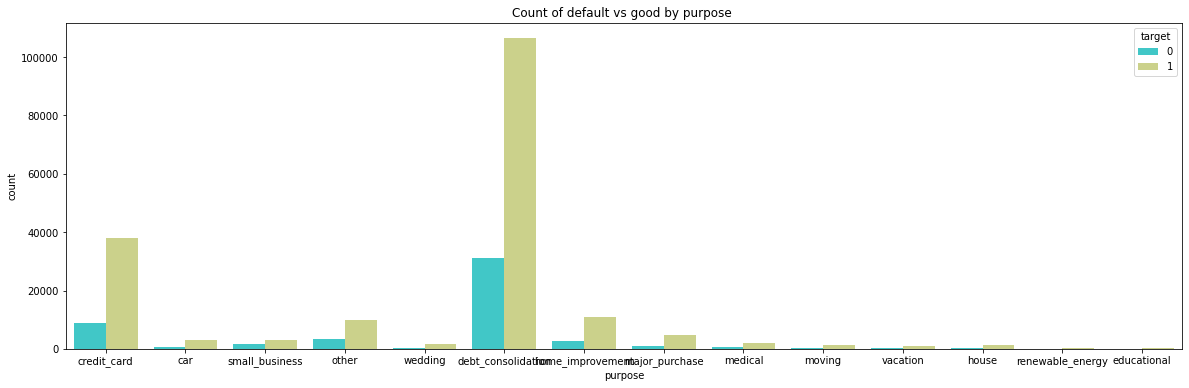

In [63]:
plt.figure(figsize=(20,6))
sns.countplot(x='purpose',data=df_new, palette='rainbow',hue='target')
plt.title("Count of default vs good by purpose ")

Text(0.5, 1.0, 'Count of default vs good by verification_status ')

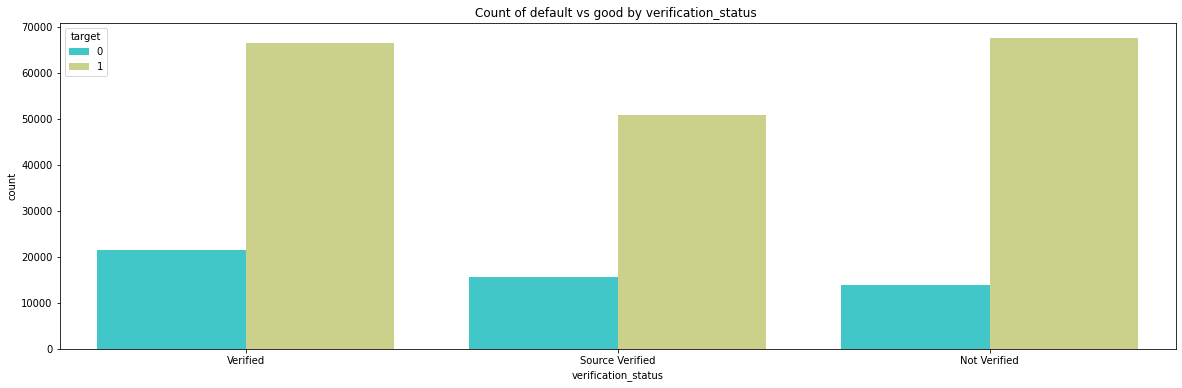

In [62]:
plt.figure(figsize=(20,6))
sns.countplot(x='verification_status',data=df_new, palette='rainbow',hue='target')
plt.title("Count of default vs good by verification_status ")

Text(0.5, 1.0, 'Count of default vs good by verification_status ')

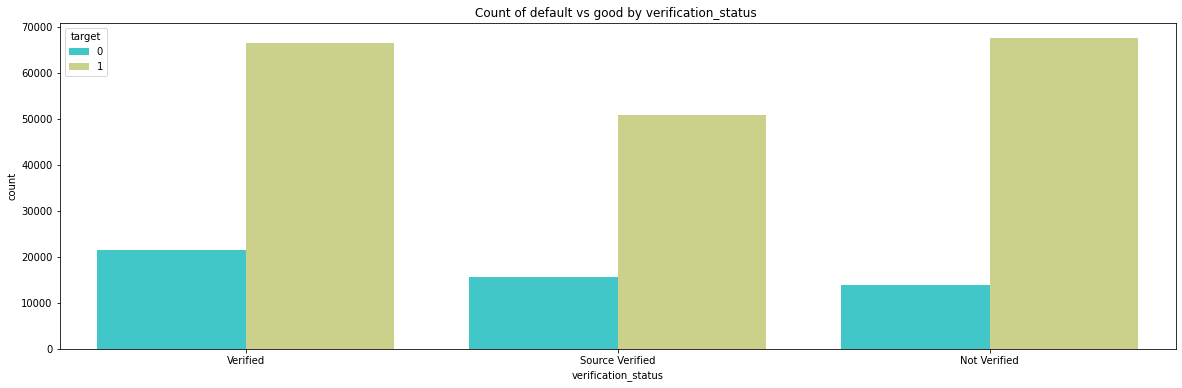

In [64]:
plt.figure(figsize=(20,6))
sns.countplot(x='verification_status',data=df_new, palette='rainbow',hue='target')
plt.title("Count of default vs good by verification_status ")

In [ ]:
df_new.shape

In [ ]:
df_new.shape

In [65]:
df_new[['addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp']].head(2)

addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0         AZ  27.65          0.0           Jan-85             1.0   
1         GA   1.00          0.0           Apr-99             5.0   

   mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  \
0                     NaN       3.0      0.0      13648        83.7   
1                     NaN       3.0      0.0       1687         9.4   

   total_acc initial_list_status  out_prncp  
0        9.0                   f        0.0  
1        4.0                   f        0.0

In [66]:
df_new["initial_list_status"].value_counts() #-- binn

f    175058
w     60649
Name: initial_list_status, dtype: int64

In [67]:
df_new[['out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type']].head(2)

out_prncp_inv  total_pymnt  total_pymnt_inv last_pymnt_d  last_pymnt_amnt  \
0            0.0  5861.071414          5831.78       Jan-15           171.62   
1            0.0  1008.710000          1008.71       Apr-13           119.66   

  next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  policy_code  \
0          NaN             Jan-16                         0.0            1   
1          NaN             Sep-13                         0.0            1   

  application_type  
0       INDIVIDUAL  
1       INDIVIDUAL

In [68]:
df_new["collections_12_mths_ex_med"].value_counts() #-- binn

0.0    234332
1.0      1220
2.0        66
3.0         7
4.0         2
5.0         1
6.0         1
Name: collections_12_mths_ex_med, dtype: int64

Text(0.5, 1.0, 'Count of default vs good by verification_status ')

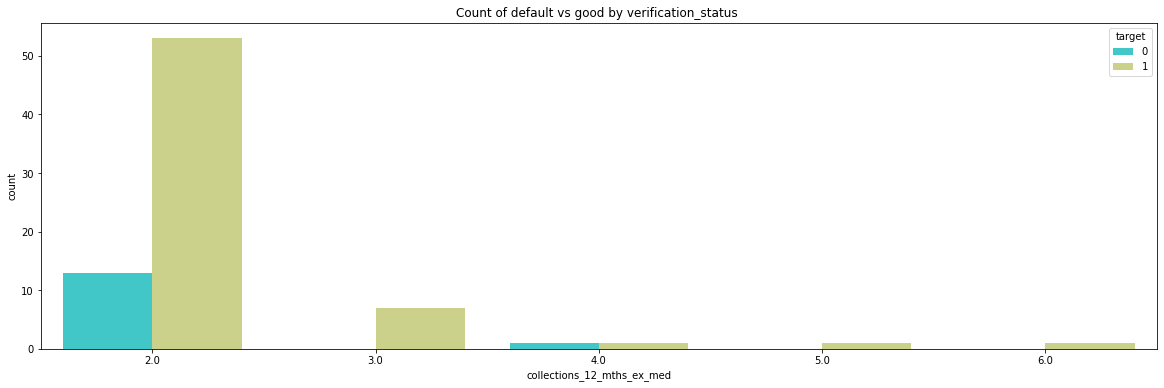

In [69]:
# Highly skewed.. willl be biased when coll is 4
plt.figure(figsize=(20,6))
sns.countplot(x='collections_12_mths_ex_med',data=df_new[df_new["collections_12_mths_ex_med"]>1], palette='rainbow',hue='target')
plt.title("Count of default vs good by verification_status ")

In [70]:
df_new["mths_since_last_delinq"].value_counts() #-- binn

12.0     1908
8.0      1904
9.0      1902
14.0     1899
10.0     1891
         ... 
103.0       1
113.0       1
100.0       1
109.0       1
152.0       1
Name: mths_since_last_delinq, Length: 125, dtype: int64

Text(0.5, 1.0, 'Count of default vs good by inq_last_6mths ')

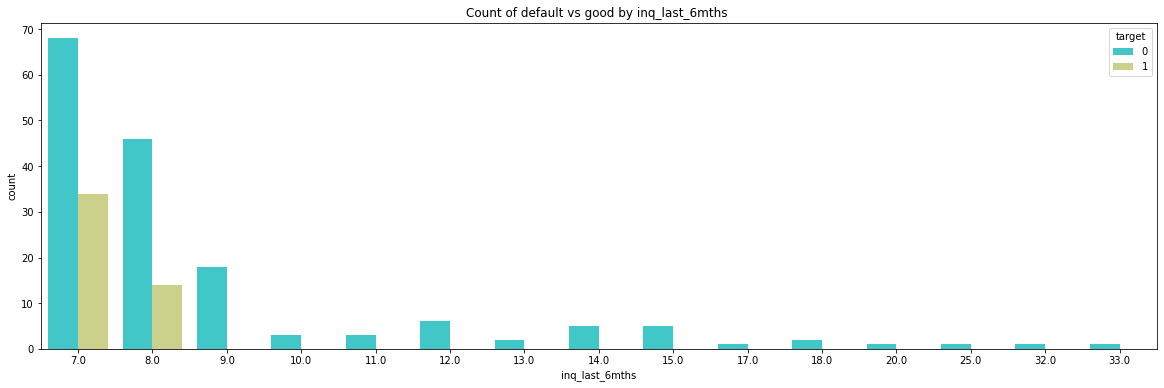

In [71]:
# skewed but informative.. can see more inq.. more default .. credit hungary borrower
plt.figure(figsize=(20,6))
sns.countplot(x='inq_last_6mths',data=df_new[df_new["inq_last_6mths"]>6], palette='rainbow',hue='target')
plt.title("Count of default vs good by inq_last_6mths ")

In [72]:
df_new[['acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'target', 'emp_years']].head(2)

acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  target  \
0             0.0           NaN          NaN               NaN       1   
1             0.0           NaN          NaN               NaN       0   

  emp_years  
0        10  
1         1

In [73]:
df_new["acc_now_delinq"].value_counts() #-- binn

0.0    235068
1.0       601
2.0        29
3.0         3
5.0         2
4.0         1
Name: acc_now_delinq, dtype: int64

Text(0.5, 1.0, 'Count of default vs good by acc_now_delinq ')

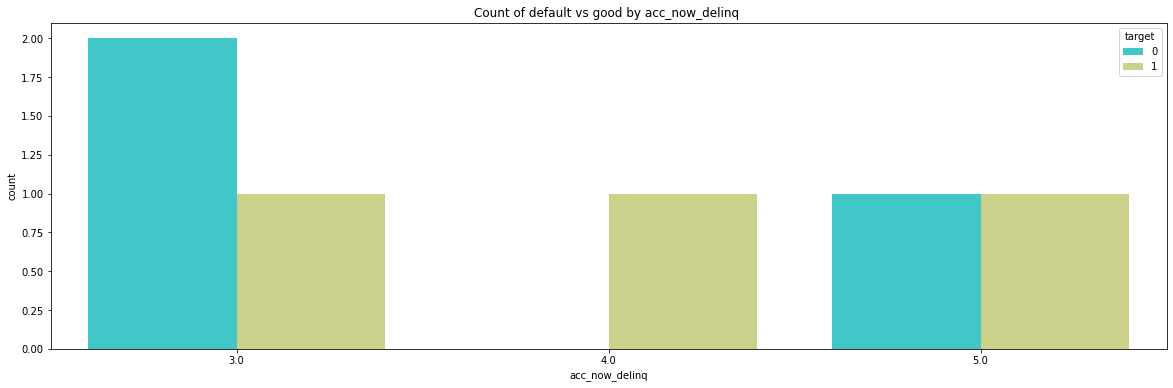

In [74]:
# 
plt.figure(figsize=(20,6))
sns.countplot(x='acc_now_delinq',data=df_new[df_new["acc_now_delinq"]>2], palette='rainbow',hue='target')
plt.title("Count of default vs good by acc_now_delinq ")

In [75]:
df_new["application_type"].value_counts() # all individual hence drop the column
df_new.drop("application_type",inplace=True,axis=1)

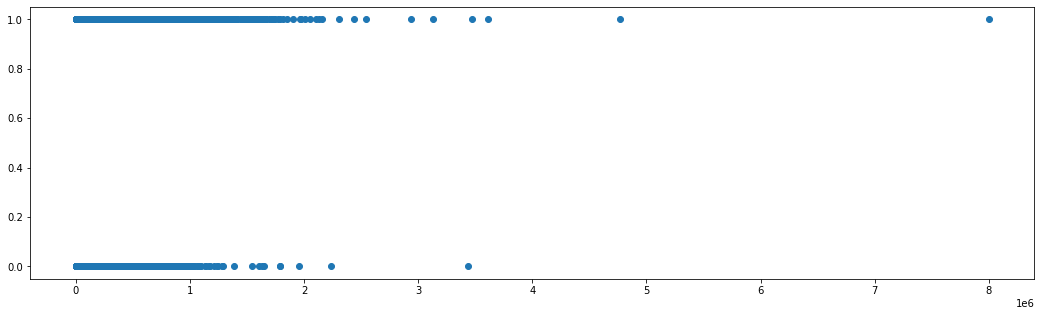

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,5))
plt.scatter(x="tot_cur_bal", y="target", data=df_new)
plt.show()

In [77]:
numerical = [var_1 for var_1 in df_new.columns if df_new[var_1].dtype=='int64' or df_new[var_1].dtype=='float64']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 27 numerical variables

The numerical variables are :

 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']


In [78]:
objectt = [var_1 for var_1 in df_new.columns if df_new[var_1].dtype=='O']

print('There are {} categorical variables\n'.format(len(objectt)))

print('The categorical variables are :\n\n', objectt)

There are 16 categorical variables

The categorical variables are :

 ['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'emp_years']


In [79]:
from sklearn import preprocessing

In [80]:
df_new[objectt]

term grade sub_grade                              emp_title  \
0        36     B        B2                                    NaN   
1        60     C        C4                                  Ryder   
2        36     C        C5                                    NaN   
3        36     C        C1                    AIR RESOURCES BOARD   
5        36     A        A4                   Veolia Transportaton   
...     ...   ...       ...                                    ...   
466276   60     D        D3                                MANAGER   
466277   36     A        A4                              sales rep   
466278   36     D        D3                              MecÃ¡nica   
466281   60     D        D5  Chief of Interpretation (Park Ranger)   
466283   36     A        A4                   Server Engineer Lead   

       home_ownership verification_status issue_d pymnt_plan  \
0                RENT            Verified  Dec-11          n   
1                RENT     Source Verified  Dec-11          n   
2                RENT        Not Verified  Dec-11          n   
3                RENT     Source Verified  Dec-11          n   
5                RENT     Source Verified  Dec-11          n   
...               ...                 ...     ...        ...   
466276       MORTGAGE            Verified  Jan-14          n   
466277           RENT            Verified  Jan-14          n   
466278           RENT     Source Verified  Jan-14          n   
466281       MORTGAGE            Verified  Jan-14          n   
466283            OWN            Verified  Jan-14          n   

                   purpose addr_state earliest_cr_line initial_list_status  \
0              credit_card         AZ           Jan-85                   f   
1                      car         GA           Apr-99                   f   
2           small_business         IL           Nov-01                   f   
3                    other         CA           Feb-96                   f   
5                  wedding         AZ           Nov-04                   f   
...                    ...        ...              ...                 ...   
466276             medical         MA           Nov-94                   f   
466277  debt_consolidation         MD           Jul-98                   f   
466278            vacation         VA           Jun-02                   f   
466281  debt_consolidation         TN           Jun-97                   f   
466283         credit_card         CA           Feb-03                   w   

       last_pymnt_d next_pymnt_d last_credit_pull_d emp_years  
0            Jan-15          NaN             Jan-16        10  
1            Apr-13          NaN             Sep-13         1  
2            Jun-14          NaN             Jan-16        10  
3            Jan-15          NaN             Jan-15        10  
5            Jan-15          NaN             Sep-15         3  
...             ...          ...                ...       ...  
466276       May-14          NaN             Oct-14         5  
466277       Nov-14          NaN             Oct-14         3  
466278       Sep-15          NaN             Jan-16        10  
466281       Dec-14          NaN             Jan-16        10  
466283       Dec-14          NaN             Apr-15         3  

[235707 rows x 16 columns]

In [81]:
# Feature selection
from sklearn.feature_selection import chi2


In [82]:
y = df_new['target']
X = df_new.drop('target',axis=1)

In [85]:
#chi_scores = chi2(X,y)

In [87]:
df_updated=df_new
df_updated.reset_index(drop=True, inplace=True)

In [88]:
from sklearn import preprocessing
import numpy as np
dict_recat = {}
for var in objectt:
    lb_make = preprocessing.LabelEncoder()
    df_updated[var] = lb_make.fit_transform(df_updated[var])
    mapping = dict(zip(lb_make.classes_, range(len(lb_make.classes_))))
    print(mapping)
    dict_recat.update({var : np.array([*mapping])})

{' 36': 0, ' 60': 1}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
{'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9, 'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24, 'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29, 'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34}
{'       NSA Industries llc': 0, '   Bus Operator and Instructor': 1, '   Long Ilsand College Hospital': 2, '  BUS OPERATER': 3, '  Golf Sevice Manager/ Caddie Master': 4, '  old palm inc': 5, ' (RED),  a division of The ONE Campaign': 6, ' A Bell Pest Services': 7, ' A Red Thread Adoption Services, Inc.': 8, ' ABC Supply Company': 9, ' ADM': 10, ' ADVANTAGE SEPTIC SERVICE': 11, ' Airway Transportation System Specialist': 12, ' Andover Sub-Acute &Rehab Center': 13, ' Area Sales Manager': 14, ' Best Buy': 15, ' Box Cleaning  ': 16, ' Brocade Communications': 17, ' BusAttendan

In [89]:
dict_recat

{'term': array([' 36', ' 60'], dtype='<U3'),
 'grade': array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='<U1'),
 'sub_grade': array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
        'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
        'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
        'G4', 'G5'], dtype='<U2'),
 'emp_title': array(['       NSA Industries llc', '   Bus Operator and Instructor',
        '   Long Ilsand College Hospital', ..., 'zozaya officiating',
        'zueck transportation', 'nan'], dtype='<U78'),
 'home_ownership': array(['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'], dtype='<U8'),
 'verification_status': array(['Not Verified', 'Source Verified', 'Verified'], dtype='<U15'),
 'issue_d': array(['Apr-08', 'Apr-09', 'Apr-10', 'Apr-11', 'Apr-12', 'Apr-13',
        'Apr-14', 'Aug-07', 'Aug-08', 'Aug-09', 'Aug-10', 'Aug-11',
        'Aug-12', 'Aug-13', 'Aug-14', 'Dec-07', 'Dec-08', 'Dec-09',
        

In [62]:
df_updated[numerical]

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0            5000         5000           4975.0     10.65       162.87   
1            2500         2500           2500.0     15.27        59.83   
2            2400         2400           2400.0     15.96        84.33   
3           10000        10000          10000.0     13.49       339.31   
4            5000         5000           5000.0      7.90       156.46   
...           ...          ...              ...       ...          ...   
235702       8525         8525           8525.0     18.25       217.65   
235703      18000        18000          17975.0      7.90       563.23   
235704      10000        10000          10000.0     18.25       362.78   
235705      22000        22000          22000.0     19.97       582.50   
235706       2000         2000           2000.0      7.90        62.59   

        annual_inc    dti  delinq_2yrs  inq_last_6mths  \
0          24000.0  27.65          0.0             1.0   
1          30000.0   1.00          0.0             5.0   
2          12252.0   8.72          0.0             2.0   
3          49200.0  20.00          0.0             1.0   
4          36000.0  11.20          0.0             3.0   
...            ...    ...          ...             ...   
235702     37536.0  12.28          4.0             0.0   
235703     90000.0  10.33          1.0             0.0   
235704     42000.0  11.57          0.0             0.0   
235705     78000.0  18.45          0.0             5.0   
235706     83000.0   5.39          3.0             1.0   

        mths_since_last_delinq  ...   total_pymnt  total_pymnt_inv  \
0                          NaN  ...   5861.071414          5831.78   
1                          NaN  ...   1008.710000          1008.71   
2                          NaN  ...   3003.653644          3003.65   
3                         35.0  ...  12226.302210         12226.30   
4                          NaN  ...   5631.377753          5631.38   
...                        ...  ...           ...              ...   
235702                     3.0  ...   2029.930000          2029.93   
235703                    14.0  ...   5631.670000          5623.85   
235704                    29.0  ...  12394.165200         12394.17   
235705                     NaN  ...   4677.920000          4677.92   
235706                    13.0  ...   2126.579838          2126.58   

        last_pymnt_amnt  collections_12_mths_ex_med  policy_code  \
0                171.62                         0.0            1   
1                119.66                         0.0            1   
2                649.91                         0.0            1   
3                357.48                         0.0            1   
4                161.03                         0.0            1   
...                 ...                         ...          ...   
235702           217.65                         0.0            1   
235703           563.23                         0.0            1   
235704          5501.60                         0.0            1   
235705            17.50                         0.0            1   
235706          1500.68                         0.0            1   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  target  
0                  0.0           NaN          NaN               NaN       1  
1                  0.0           NaN          NaN               NaN       0  
2                  0.0           NaN          NaN               NaN       1  
3                  0.0           NaN          NaN               NaN       1  
4                  0.0           NaN          NaN               NaN       1  
...                ...           ...          ...               ...     ...  
235702             0.0           0.0     116995.0           49800.0       0  
235703             0.0           0.0      42592.0           50300.0       0  
235704             0.0           0.0      10170.0           11

In [92]:
df_final = df_updated[numerical + objectt]

In [93]:
df_final

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0            5000         5000           4975.0     10.65       162.87   
1            2500         2500           2500.0     15.27        59.83   
2            2400         2400           2400.0     15.96        84.33   
3           10000        10000          10000.0     13.49       339.31   
4            5000         5000           5000.0      7.90       156.46   
...           ...          ...              ...       ...          ...   
235702       8525         8525           8525.0     18.25       217.65   
235703      18000        18000          17975.0      7.90       563.23   
235704      10000        10000          10000.0     18.25       362.78   
235705      22000        22000          22000.0     19.97       582.50   
235706       2000         2000           2000.0      7.90        62.59   

        annual_inc    dti  delinq_2yrs  inq_last_6mths  \
0          24000.0  27.65          0.0             1.0   
1          30000.0   1.00          0.0             5.0   
2          12252.0   8.72          0.0             2.0   
3          49200.0  20.00          0.0             1.0   
4          36000.0  11.20          0.0             3.0   
...            ...    ...          ...             ...   
235702     37536.0  12.28          4.0             0.0   
235703     90000.0  10.33          1.0             0.0   
235704     42000.0  11.57          0.0             0.0   
235705     78000.0  18.45          0.0             5.0   
235706     83000.0   5.39          3.0             1.0   

        mths_since_last_delinq  ...  issue_d  pymnt_plan  purpose  addr_state  \
0                          NaN  ...       19           0        1           3   
1                          NaN  ...       19           0        0          10   
2                          NaN  ...       19           0       11          14   
3                         35.0  ...       19           0        9           4   
4                          NaN  ...       19           0       13           3   
...                        ...  ...      ...         ...      ...         ...   
235702                     3.0  ...       36           0        7          19   
235703                    14.0  ...       36           0        2          20   
235704                    29.0  ...       36           0       12          44   
235705                     NaN  ...       36           0        2          41   
235706                    13.0  ...       36           0        1           4   

        earliest_cr_line  initial_list_status  last_pymnt_d  next_pymnt_d  \
0                    249                    0            40            71   
1                     50                    0             5            71   
2                    470                    0            56            71   
3                    202                    0            40            71   
4                    473                    0            40            71   
...                  ...                  ...           ...           ...   
235702               520                    0            72            71   
235703               313                    0            80            71   
235704               317                    0            97            71   
235705               363                    0            23            71   
235706               160                    1            23            71   

        last_credit_pull_d  emp_years  
0                       41          1  
1                       99          0  
2                       41          1  
3                       40          1  
4                      101          3  
...                    ...        ...  
235702                  91          5  
235703                  91          3  
235704                  41          1  
235705                  41          1  
235706                   6          3  

[235707 rows x 43 columns]

In [94]:
df_final.describe()

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  235707.000000  235707.000000    235707.000000  235707.000000   
mean    13513.329791   13468.760898     13358.052670      13.843516   
std      8064.319558    8039.545746      8065.318448       4.390079   
min       500.000000     500.000000         0.000000       5.420000   
25%      7300.000000    7200.000000      7200.000000      10.990000   
50%     12000.000000   12000.000000     11950.000000      13.660000   
75%     18000.000000   18000.000000     18000.000000      16.590000   
max     35000.000000   35000.000000     35000.000000      26.060000   

         installment    annual_inc            dti    delinq_2yrs  \
count  235707.000000  2.357070e+05  235707.000000  235704.000000   
mean      417.716184  7.192445e+04      16.448051       0.247289   
std       243.646712  5.501004e+04       7.694201       0.733228   
min        15.690000  2.000000e+03       0.000000       0.000000   
25%       240.350000  4.500000e+04      10.730000       0.000000   
50%       365.300000  6.154800e+04      16.150000       0.000000   
75%       546.345000  8.600000e+04      21.890000       0.000000   
max      1408.130000  7.141778e+06      39.990000      29.000000   

       inq_last_6mths  mths_since_last_delinq  ...        issue_d  \
count   235704.000000           103619.000000  ...  235707.000000   
mean         0.881118               35.014708  ...      47.918895   
std          1.112303               21.803956  ...      26.415452   
min          0.000000                0.000000  ...       0.000000   
25%          0.000000               17.000000  ...      25.000000   
50%          1.000000               32.000000  ...      50.000000   
75%          1.000000               51.000000  ...      72.000000   
max         33.000000              152.000000  ...      90.000000   

          pymnt_plan        purpose     addr_state  earliest_cr_line  \
count  235707.000000  235707.000000  235707.000000     235707.000000   
mean        0.000025       2.847187      22.133831        322.860636   
std         0.005045       2.621006      14.885004        186.452750   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       2.000000       6.000000        156.000000   
50%         0.000000       2.000000      22.000000        317.000000   
75%         0.000000       2.000000      34.000000        475.000000   
max         1.000000      13.000000      49.000000        634.000000   

       initial_list_status   last_pymnt_d   next_pymnt_d  last_credit_pull_d  \
count        235707.000000  235707.000000  235707.000000       235707.000000   
mean              0.257307      52.813094      69.275775           48.363668   
std               0.437151      28.602329       9.040056           24.040064   
min               0.000000       0.000000       0.000000            0.000000   
25%               0.000000      24.000000      71.000000           41.000000   
50%               0.000000      55.000000      71.000000           41.000000   
75%               1.000000      80.000000      71.000000           59.000000   
max               1.000000      98.000000      71.000000          102.000000   

           emp_years  
count  235707.000000  
mean        3.204173  
std         2.968941  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         5.000000  
max        10.000000  

[8 rows x 43 columns]

In [95]:
df_final.shape

(235707, 43)

In [69]:
df_final.shape

(235707, 43)

In [ ]:
# post default cols
#df_final.drop(["annual_inc_joint","recoveries"],axis=1,inplace=True)

In [130]:
df_final.isna().any()

loan_amnt                     False
funded_amnt                   False
funded_amnt_inv               False
int_rate                      False
installment                   False
annual_inc                    False
dti                           False
delinq_2yrs                    True
inq_last_6mths                 True
mths_since_last_delinq         True
open_acc                       True
pub_rec                        True
revol_bal                     False
revol_util                     True
total_acc                      True
out_prncp                     False
out_prncp_inv                 False
total_pymnt                   False
total_pymnt_inv               False
last_pymnt_amnt               False
collections_12_mths_ex_med     True
policy_code                   False
acc_now_delinq                 True
tot_coll_amt                   True
tot_cur_bal                    True
total_rev_hi_lim               True
target                        False
term                        

In [114]:
contains_null = ['delinq_2yrs',"inq_last_6mths","mths_since_last_delinq","open_acc",'pub_rec',"revol_util","total_acc","collections_12_mths_ex_med","acc_now_delinq","tot_coll_amt","tot_cur_bal","total_rev_hi_lim"]

In [115]:
df_final[contains_null]

delinq_2yrs  inq_last_6mths  mths_since_last_delinq  open_acc  \
0               0.0             1.0                     NaN       3.0   
1               0.0             5.0                     NaN       3.0   
2               0.0             2.0                     NaN       2.0   
3               0.0             1.0                    35.0      10.0   
4               0.0             3.0                     NaN       9.0   
...             ...             ...                     ...       ...   
235702          4.0             0.0                     3.0      12.0   
235703          1.0             0.0                    14.0      16.0   
235704          0.0             0.0                    29.0       9.0   
235705          0.0             5.0                     NaN      18.0   
235706          3.0             1.0                    13.0      21.0   

        pub_rec  revol_util  total_acc  collections_12_mths_ex_med  \
0           0.0        83.7        9.0                         0.0   
1           0.0         9.4        4.0                         0.0   
2           0.0        98.5       10.0                         0.0   
3           0.0        21.0       37.0                         0.0   
4           0.0        28.3       12.0                         0.0   
...         ...         ...        ...                         ...   
235702      0.0        10.7       26.0                         0.0   
235703      0.0        16.3       33.0                         0.0   
235704      0.0        28.8       24.0                         0.0   
235705      1.0        46.3       30.0                         0.0   
235706      0.0        21.5       27.0                         0.0   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0           NaN          NaN               NaN  
1                  0.0           NaN          NaN               NaN  
2                  0.0           NaN          NaN               NaN  
3                  0.0           NaN          NaN               NaN  
4                  0.0           NaN          NaN               NaN  
...                ...           ...          ...               ...  
235702             0.0           0.0     116995.0           49800.0  
235703             0.0           0.0      42592.0           50300.0  
235704             0.0           0.0      10170.0           11100.0  
235705             0.0           0.0     221830.0           39400.0  
235706             0.0           0.0     591610.0           53100.0  

[235707 rows x 12 columns]

In [154]:
df_final[["mths_since_last_delinq","tot_coll_amt","tot_cur_bal","total_rev_hi_lim","collections_12_mths_ex_med","revol_util"]]

mths_since_last_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  \
0                       -999.0        -999.0       -999.0            -999.0   
1                       -999.0        -999.0       -999.0            -999.0   
2                       -999.0        -999.0       -999.0            -999.0   
3                         35.0        -999.0       -999.0            -999.0   
4                       -999.0        -999.0       -999.0            -999.0   
...                        ...           ...          ...               ...   
235702                     3.0           0.0     116995.0           49800.0   
235703                    14.0           0.0      42592.0           50300.0   
235704                    29.0           0.0      10170.0           11100.0   
235705                  -999.0           0.0     221830.0           39400.0   
235706                    13.0           0.0     591610.0           53100.0   

        collections_12_mths_ex_med  revol_util  
0                              0.0        83.7  
1                              0.0         9.4  
2                              0.0        98.5  
3                              0.0        21.0  
4                              0.0        28.3  
...                            ...         ...  
235702                         0.0        10.7  
235703                         0.0        16.3  
235704                         0.0        28.8  
235705                         0.0        46.3  
235706                         0.0        21.5  

[235707 rows x 6 columns]

In [153]:
df_final[contains_null].min().min()
df_final=df_final.fillna(-999)

In [167]:
df_final.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
int_rate                      0
installment                   0
annual_inc                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
policy_code                   0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
target                        0
term                          0
grade                         0
sub_grade                     0
emp_title                     0
home_own

In [168]:
'''from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(columns=['target']), df_final['target'], test_size=0.33, random_state=42)'''

In [169]:
X = df_final.drop('target', axis = 1)
y = df_final['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test = X_train.copy(), X_test.copy()

In [170]:
df_temp = X_train.copy()
ret_bins = pd.DataFrame()
for col in df_temp[df_temp.columns[~df_temp.columns.isin(contains_null)]].columns:
    df_temp[col] = pd.qcut(df_temp[col], 7, duplicates='drop')

In [171]:
import numpy as np
dict_recat2 = {}
for var in df_temp[df_temp.columns[~df_temp.columns.isin(contains_null)]].columns:
    lb_make2 = preprocessing.LabelEncoder()
    df_temp[var] = lb_make2.fit_transform(df_temp[var])
    mapping2 = dict(zip(lb_make2.classes_, range(len(lb_make2.classes_))))
    print(mapping2)
    dict_recat2.update({var : np.array([*mapping2])})

{Interval(499.999, 5250.0, closed='right'): 0, Interval(5250.0, 8000.0, closed='right'): 1, Interval(8000.0, 10000.0, closed='right'): 2, Interval(10000.0, 13225.0, closed='right'): 3, Interval(13225.0, 17000.0, closed='right'): 4, Interval(17000.0, 22800.0, closed='right'): 5, Interval(22800.0, 35000.0, closed='right'): 6}
{Interval(499.999, 5200.0, closed='right'): 0, Interval(5200.0, 8000.0, closed='right'): 1, Interval(8000.0, 10000.0, closed='right'): 2, Interval(10000.0, 13200.0, closed='right'): 3, Interval(13200.0, 17000.0, closed='right'): 4, Interval(17000.0, 22500.0, closed='right'): 5, Interval(22500.0, 35000.0, closed='right'): 6}
{Interval(-0.001, 5000.0, closed='right'): 0, Interval(5000.0, 8000.0, closed='right'): 1, Interval(8000.0, 10000.0, closed='right'): 2, Interval(10000.0, 13000.0, closed='right'): 3, Interval(13000.0, 16950.0, closed='right'): 4, Interval(16950.0, 22400.0, closed='right'): 5, Interval(22400.0, 35000.0, closed='right'): 6}
{Interval(5.419, 8.9, c

In [172]:
bins=[]

In [173]:
df_temp = X_train.copy()
ret_bins = pd.DataFrame()
for col in contains_null:
    temp, bins = pd.qcut(df_temp[col], 7, duplicates='drop', retbins=True)
    #bins=list(bins)
    print(bins)
   # bins.insert(1, -1.0)
    bins = [-1000.0 if x==-999.0 else x for x in bins]
    print(bins)
    df_temp[col] = pd.cut(df_temp[col], bins, duplicates='drop')

[-999.    0.    1.   29.]
[-1000.0, 0.0, 1.0, 29.0]
[-999.    0.    1.    2.   33.]
[-1000.0, 0.0, 1.0, 2.0, 33.0]
[-999.    3.   22.   45.  152.]
[-1000.0, 3.0, 22.0, 45.0, 152.0]
[-999.    6.    8.    9.   11.   13.   16.   76.]
[-1000.0, 6.0, 8.0, 9.0, 11.0, 13.0, 16.0, 76.0]
[-999.    0.   11.]
[-1000.0, 0.0, 11.0]
[-999.    25.9   40.4   51.5   61.6   71.7   83.1  892.3]
[-1000.0, 25.9, 40.4, 51.5, 61.6, 71.7, 83.1, 892.3]
[-999.   13.   17.   21.   25.   30.   37.  118.]
[-1000.0, 13.0, 17.0, 21.0, 25.0, 30.0, 37.0, 118.0]
[-999.    0.    5.]
[-1000.0, 0.0, 5.0]
[-999.    0.    5.]
[-1000.0, 0.0, 5.0]
[-9.990000e+02  0.000000e+00  9.152545e+06]
[-1000.0, 0.0, 9152545.0]
[-9.99000000e+02  4.46300000e+03  2.42731429e+04  5.06408571e+04
  1.34194571e+05  2.39110857e+05  8.00007800e+06]
[-1000.0, 4463.0, 24273.142857142855, 50640.85714285713, 134194.57142857136, 239110.85714285713, 8000078.0]
[-9.990000e+02  3.800000e+03  1.200000e+04  1.860000e+04  2.700000e+04
  4.120000e+04  2.013

In [174]:
import numpy as np
dict_recat3 = {}
for var in contains_null:
    lb_make3 = preprocessing.LabelEncoder()
    df_temp[var] = lb_make3.fit_transform(df_temp[var])
    mapping3 = dict(zip(lb_make3.classes_, range(len(lb_make3.classes_))))
    print(mapping3)
    dict_recat3.update({var : np.array([*mapping3])})

{Interval(-1000.0, 0.0, closed='right'): 0, Interval(0.0, 1.0, closed='right'): 1, Interval(1.0, 29.0, closed='right'): 2}
{Interval(-1000.0, 0.0, closed='right'): 0, Interval(0.0, 1.0, closed='right'): 1, Interval(1.0, 2.0, closed='right'): 2, Interval(2.0, 33.0, closed='right'): 3}
{Interval(-1000.0, 3.0, closed='right'): 0, Interval(3.0, 22.0, closed='right'): 1, Interval(22.0, 45.0, closed='right'): 2, Interval(45.0, 152.0, closed='right'): 3}
{Interval(-1000.0, 6.0, closed='right'): 0, Interval(6.0, 8.0, closed='right'): 1, Interval(8.0, 9.0, closed='right'): 2, Interval(9.0, 11.0, closed='right'): 3, Interval(11.0, 13.0, closed='right'): 4, Interval(13.0, 16.0, closed='right'): 5, Interval(16.0, 76.0, closed='right'): 6}
{Interval(-1000.0, 0.0, closed='right'): 0, Interval(0.0, 11.0, closed='right'): 1}
{Interval(-1000.0, 25.9, closed='right'): 0, Interval(25.9, 40.4, closed='right'): 1, Interval(40.4, 51.5, closed='right'): 2, Interval(51.5, 61.6, closed='right'): 3, Interval(61

In [175]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(df_temp, y_train)

In [176]:
clf.predict_proba(X_train)

array([[1.85845415e-03, 9.98141546e-01],
       [4.90828597e-07, 9.99999509e-01],
       [1.07222742e-09, 9.99999999e-01],
       ...,
       [9.99999915e-01, 8.51988930e-08],
       [1.12045497e-05, 9.99988795e-01],
       [1.16972213e-06, 9.99998830e-01]])

In [184]:
roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]), roc_auc_score(y_train, clf.decision_function(X_train))

(0.9957372820078023, 0.9957380356548673)

In [179]:
clf.predict_proba(X_test)

array([[1.09083358e-04, 9.99890917e-01],
       [1.00000000e+00, 7.51104960e-15],
       [9.99999429e-01, 5.70891950e-07],
       ...,
       [9.95108997e-01, 4.89100265e-03],
       [3.04082341e-05, 9.99969592e-01],
       [2.22044605e-16, 1.00000000e+00]])

In [185]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, clf.decision_function(X_test))

(0.9956506807875257, 0.9956517029623145)